In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.externals import joblib
from keras.models import Sequential, load_model, Model
from keras.layers import Conv2D, MaxPool2D, Flatten, Activation, Layer, Dense
from scipy.spatial import distance
from packages.Utility.SVM.SVM import *
from packages.Utility.SVM.Kernel import *
from packages.Utility.CNN.Callbacks import SaveModel
from packages.Utility.DatasetManager import DatasetReader
from packages.Utility.CNN.FeatureManager import FeatureExtractor, FeatureReader, FeatureWriter
from packages.Utility.Metrics import ConfusionMatrix, CNN_Evaluator, SVM_Evaluator
from packages.Utility.Gabor import GaborFilterBanks, GaborParams, RotatedGaborParams

Using TensorFlow backend.


# Memuat Dataset

In [2]:
reader = DatasetReader('dataset/bin/digit 32x32 50k')
fold = 0

X_train, Y_train_onehot, Y_train_single = reader.getTrainData(fold)
X_test, Y_test_onehot, Y_test_single = reader.getTestData(fold)

# Pra-Training

In [3]:
save_model = SaveModel(base_dir = 'trained/digit 32x32 50k LN1', X_val = X_train, Y_val = Y_train_onehot)

# Mendefinisikan Model CNN
Mendefinisikan arsitektur CNN

In [4]:
model = Sequential()

c1 = Conv2D(name='c1', filters = 6, kernel_initializer = GaborFilterBanks(RotatedGaborParams(lambd = 0.5, psi = 1.57, sigma = 2, gamma = 0.75)),
            kernel_size = 5, strides = 1, padding = 'valid', activation = 'relu', 
            input_shape = (32, 32, 1))
c2 = Conv2D(name='c2', filters = 16, kernel_initializer = GaborFilterBanks(RotatedGaborParams(lambd = 0.5, psi = 1.57, sigma = 2, gamma = 0.75)), 
            kernel_size = 5, strides = 1, padding = 'valid', activation = 'relu')
m1 = MaxPool2D(pool_size = 2)
m2 = MaxPool2D(pool_size = 2)
f1 = Flatten(name = 'flatten')
model.add(c1)
model.add(m1)
model.add(c2)
model.add(m2)
model.add(f1)
model.add(Dense(10, activation = 'softmax', name = 'd3'))

# Melakukan Pelatihan
Melakukan pelatihan pada CNN

In [5]:
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
history = model.fit(X_train, Y_train_onehot, epochs = 1, verbose = 1, batch_size = 128, callbacks=[save_model])

Epoch 1/1
37500/37500 [==============================] - 627s 17ms/step - loss: 0.1648 - acc: 0.1757
val_acc: 0.161


## Menghitung Akurasi CNN
Menampilkan Confusion Matrix Terhadap Data Training dan Testing

In [10]:
ev = CNN_Evaluator(model = model, labels = reader.labels)
y_true_train, y_pred_train, score = ev.evaluate(X_train, Y_train_single)
y_true_test, y_pred_test, score = ev.evaluate(X_test, Y_test_single)

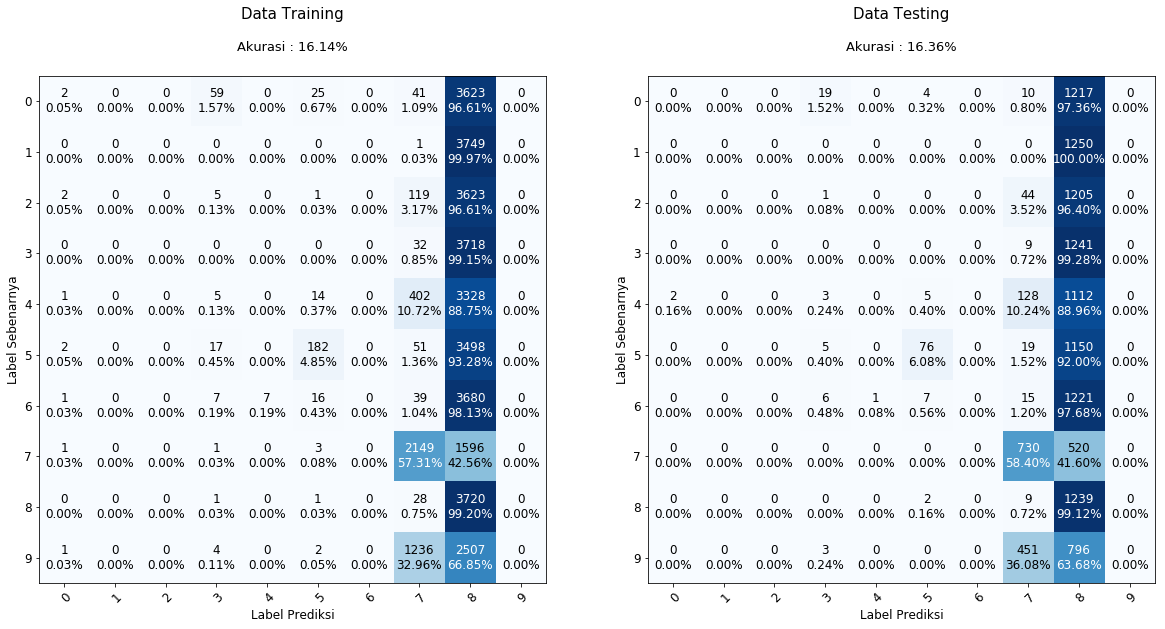

In [11]:
# Confusion Matrix
cfm = ConfusionMatrix((20, 10), 1, 2, reader.labels)
cfm.xylabel_size = 12
cfm.add(y_true_train, y_pred_train, 0, 0, 'Data Training')
cfm.add(y_true_test, y_pred_test, 0, 1, 'Data Testing')
cfm.show()

# Ekstraksi Fitur
Melakukan ekstraksi fitur pada layer flatten

In [36]:
extractor = FeatureExtractor(model, output_layer = 'flatten')
feature_train = extractor.extract(X_train)
feature_test = extractor.extract(X_test)

# Menyimpan Fitur ke Dalam File

In [17]:
# f_writer = FeatureWriter(feature_train, reader.dataset[reader.folds[fold, 0]])
# f_writer.write('tes.npy')

# f_reader = FeatureReader('tes.npy')
# f = f_reader.read()
# reader.dataset[np.where(f[:, 1] == 0)].shape

# Melakukan Pelatihan dengan SVM
Data dari Flatten layer dilatih pada SVM dan
diuji akurasinya

In [34]:
cls = svm.SVC(kernel = 'linear', max_iter = 50000, C = 100, decision_function_shape='ovo', verbose = True)
cls.fit(feature_train, Y_train_single)
# joblib.dump(cls, 'trained/trained_svm_digit.sav')

[LibSVM]

c:\python\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=50000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovo', degree=3, gamma='auto', kernel='linear',
  max_iter=50000, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=True)

## Akurasi SVM

In [37]:
from packages.Utility.Metrics import CNN_SVM_Evaluator

ev = CNN_SVM_Evaluator(model = cls, labels = reader.labels)
y_true_train, y_pred_train, score = ev.evaluate(feature_train, Y_train_single)
y_true_test, y_pred_test, score = ev.evaluate(feature_test, Y_test_single)

In [1]:
# Confusion Matrix
cfm = ConfusionMatrix((25, 10), 1, 2, reader.labels)
cfm.xylabel_size = 12
cfm.add(y_true_train, y_pred_train, 'Data Training')
cfm.add(y_true_test, y_pred_test, 'Data Testing')
cfm.show()

NameError: name 'ConfusionMatrix' is not defined

# Retrieval Dengan SVM sebagai klasifikasi

Kueri acak

In [ ]:
index_kueri = np.random.randint(X_test.shape[0])
kueri = X_test[index_kueri]

### Mendapatkan fitur dari data training

In [ ]:
train_feature = feature_model.predict(X_train)

## Menggabungkan dengan dataset training

In [ ]:
collection = np.append(dataset[fold[0, 0]], train_feature, axis = 1)

### Klasifikasi kueri

In [ ]:
# cls = joblib.load('trained/trained_svm_digit.sav')
ftr = feature_model.predict(np.array([kueri]))
pred = cls.predict(ftr)

### Mendapatkan daftar citra sesuai hasil klasifikasi

In [ ]:
box = collection[np.where(collection[:, 1] == pred[0])]

### Menghitung jarak

In [ ]:
jarak = []

for i in range(box.shape[0]):
    jarak.append([box[i, 3], distance.euclidean(box[i, 4:], ftr)])
    
jarak.sort(key = lambda x: x[1])    

### Menampilkan hasil

In [ ]:
print('Kelas kueri : ', dataset[fold[0, 1]][index_kueri, 1])
print('Prediksi : ', pred[0])

fig = plt.figure(figsize = (20, 20))

## menampilkn query
y = fig.add_subplot(5, 5, 1)
y.imshow(
    cv.cvtColor(cv.imread(dataset[fold[0, 1]][index_kueri, 3]), cv.COLOR_BGR2RGB)
)
plt.title('Kueri')
y.axes.get_xaxis().set_visible(False)
y.axes.get_yaxis().set_visible(False)
    
for i in range(1, 20):
    y = fig.add_subplot(5, 5, i + 1)
    y.imshow(cv.cvtColor(cv.imread(jarak[i][0]), cv.COLOR_BGR2RGB))
    plt.title('Jarak : ' + str(jarak[i][1]))
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)